# 使用torch.nn实现逻辑回归

In [30]:
import torch
import torch.nn as nn
import random
from torch.autograd import Variable
import platform
import numpy as np
import torch.utils.data as Data
import matplotlib.pyplot as plt

## 1 人工构造数据集

In [31]:
n_data = torch.ones(150, 2) # 数据的基本形态
x1 = torch.normal(2 * n_data, 1) # shape=(150, 2)
y1 = torch.zeros(150, 1) # 类型0 shape=(150, 1)
x2 = torch.normal(-2 * n_data, 1) # 类型1 shape=(150, 2) 
y2 = torch.ones(150, 1) # 类型1 shape=(150, 1)
# 注意 x, y 数据的数据形式是一定要像下面一样 (torch.cat 是在合并数据)
x = torch.cat((x1, x2), 0).type(torch.FloatTensor)
y = torch.cat((y1, y2), 0).type(torch.FloatTensor)

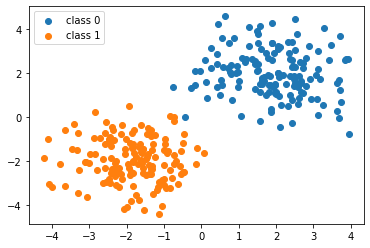

In [32]:
fig, ax = plt.subplots()
labels = ['class 0','class 1']
ax.scatter(x.numpy()[0:len(x1),0], x.numpy()[0:len(x1),1], label=labels[0])
ax.scatter(x.numpy()[len(x1):len(x),0], x.numpy()[len(x1):len(x),1], label=labels[1])
ax.legend()

In [33]:
def shuffle_data(X, y, seed=None):
    if seed:
        np.random.seed(seed)
        
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    
    return X[idx], y[idx]

In [34]:
def train_test_split(X, y, test_size=0.2, shuffle=True, seed=None):
    if shuffle:
        X, y = shuffle_data(X, y, seed)
        
    n_train_samples = int(X.shape[0] * (1-test_size))
    x_train, x_test = X[:n_train_samples], X[n_train_samples:]
    y_train, y_test = y[:n_train_samples], y[n_train_samples:]
    
    return x_train, x_test, y_train, y_test

In [35]:
 X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,shuffle=False,seed=1)

In [36]:
batch_size = 10
system = platform.system()
num_workers = 4 if system == 'Linux' else 0
dataset = Data.TensorDataset(X_train, y_train)
data_iter = Data.DataLoader(
    dataset=dataset, # torch TensorDataset format
    batch_size=batch_size, # mini batch size
    shuffle=True, # 是否打乱数据 (训练集一般需要进行打乱) 
    num_workers=num_workers, # 多线程来读数据，注意在Windows下需要设置为0
)

## 2 定义模型

In [37]:
class LogisticNet(torch.nn.Module):
    def __init__(self, features):
        super(LogisticNet, self).__init__()
        self.linear = nn.Linear(2,1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        y = self.linear(x)
        y = self.sigmoid(y)
        return y

In [38]:
logistic_model = LogisticNet(2)

## 3 定义损失函数和优化器

In [39]:
criterion = nn.BCELoss()   #选用BCE损失函数,该损失函数是只用于2分类问题的损失函数
optimizer = torch.optim.SGD(logistic_model.parameters(),lr=1e-3,momentum=0.9)  #采用随机梯度下降的方法

## 4 训练模型

In [40]:
num_epochs = 20
for epoch in range(num_epochs): # 训练模型一共需要num_epochs个迭代周期
# 在每一个迭代周期中，会使用训练数据集中所有样本一次
    for X, Y in data_iter:
        if torch.cuda.is_available():
            x_data=Variable(X).cuda()
            y_data=Variable(Y).cuda()
        else:
            x_data=Variable(X)
            y_data=Variable(Y)

        out=logistic_model(x_data)  #根据逻辑回归模型拟合出的y值

        loss=criterion(out,y_data)  #计算损失函数
        print_loss=loss.data.item()  #得出损失函数值
        mask=out.ge(0.5).float()  #以0.5为阈值进行分类
        correct=(mask==y_data).sum()  #计算正确预测的样本个数
        acc=correct.item()/x_data.size(0)  #计算精度
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #每隔20轮打印一下当前的误差和精度
    if (epoch+1)%5==0:
        print('*'*10)
        print('epoch {}'.format(epoch+1))  #误差
        print('loss is {:.4f}'.format(print_loss))
        print('acc is {:.4f}'.format(acc))  #精度

**********
epoch 5
loss is 0.1064
acc is 1.0000
**********
epoch 10
loss is 0.0896
acc is 1.0000
**********
epoch 15
loss is 0.0566
acc is 1.0000
**********
epoch 20
loss is 0.0890
acc is 1.0000


## 5 结果可视化

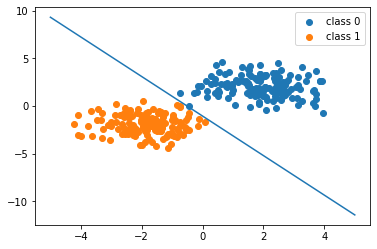

In [41]:
w1, w2 = logistic_model.linear.weight[0]
b = logistic_model.linear.bias.item()
plot_x = range(-5, 6, 1)
plot_y = [-(w1*item+b)/w2 for item in plot_x]

fig, ax = plt.subplots()
labels = ['class 0','class 1']
ax.scatter(x.numpy()[0:len(x1),0], x.numpy()[0:len(x1),1], label=labels[0])
ax.scatter(x.numpy()[len(x1):len(x),0], x.numpy()[len(x1):len(x),1], label=labels[1])
ax.legend()
ax.plot(plot_x, plot_y)

In [42]:
def accuracy(y, y_pred):
    return y == y_pred

In [43]:
test_batch_size = 1
test_dataset = Data.TensorDataset(X_test, y_test)
test_data_iter = Data.DataLoader(
    dataset=test_dataset, # torch TensorDataset format
    batch_size=test_batch_size, # mini batch size
    shuffle=True, # 是否打乱数据 (训练集一般需要进行打乱) 
    num_workers=2, # 多线程来读数据，注意在Windows下需要设置为0
)

acc_sum = 0.0
for X , Y in test_data_iter: # x和y分别是小批量样本的特征和标签
    y_pred=logistic_model(X)
    acc_sum+=accuracy(np.round(y_pred.detach().numpy()),Y.detach().numpy())
print("Test Acc: ",(acc_sum/len(y_test))[0][0])

Test Acc:  1.0


In [44]:
import pandas as pd
pre_label = torch.round(logistic_model(X_test)).detach().numpy()
true_label = y_test.detach().numpy()
label = np.hstack([pre_label,true_label])
df = pd.DataFrame(label,columns=["Predicted Label","True Label"])
df

,Predicted Label,True Label
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
...,...,...
85,1.0,1.0
86,1.0,1.0
87,1.0,1.0
88,1.0,1.0
